In [6]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import cross_val_predict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Assignment 1

In [2]:
cluster_a = make_blobs(300, n_features=2, centers=4, cluster_std=0.6, center_box = (-10.0, 10.0))
cluster_b = make_blobs(300, n_features=2, centers=4, cluster_std=0.1, center_box = (-10.0, 10.0))
cluster_c = make_blobs(300, n_features=2, centers=4, cluster_std=2.5, center_box = (-10.0, 10.0))

In [3]:
def get_clustering(cluster, std, random_state=None):
    X, y = cluster
    # X, y = make_blobs(300, n_features=2, centers=4, cluster_std=std, center_box = (-10.0, 10.0))
    fig, axs = plt.subplots(1, 11, figsize=(40,40))
    fig.suptitle(f'cluster for standard deviation = {std}, random state = {random_state}')
    df = pd.DataFrame(index=[f'actual cluster: {i}' for i in range(4)], columns=[[], []])

    sse = []
    for i in range(1, 11):
        #axs[i-1].set_size((10,10))
        kmean = KMeans(n_clusters=i, random_state=random_state)
        y_pred = kmean.fit_predict(X,y)
        centroids = kmean.cluster_centers_
        sse.append(kmean.inertia_)
        axs[i-1].scatter(X[:,0], X[:,1], c= kmean.labels_)
        axs[i-1].scatter(centroids[:,0], centroids[:,1], c=np.unique(kmean.labels_), edgecolors='red')
        axs[i-1].set(aspect='equal', title=f'nr. of clusters: {i}')


        cols = [
            [f'k = {i}'] * i,
            [f'predicted k: {j}' for j in np.arange(i)]]
        temp_df = pd.DataFrame(contingency_matrix(y, y_pred), columns=cols, index=[f'actual cluster: {i}' for i in range(4)])
        df = df.merge(temp_df, left_index=True, right_index=True)


    axs[10].plot(np.arange(1,11), sse)
    asp = np.diff(axs[10].get_xlim())[0] / np.diff(axs[10].get_ylim())[0]
    axs[10].set(aspect=asp, title=f'SSE for different k')
    axs[10].set_xticks(np.arange(1,11))
    fig.tight_layout()
    fig.set_size_inches(17, 3)
    return df

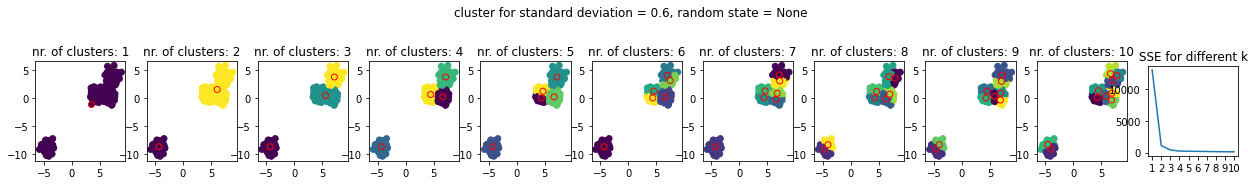

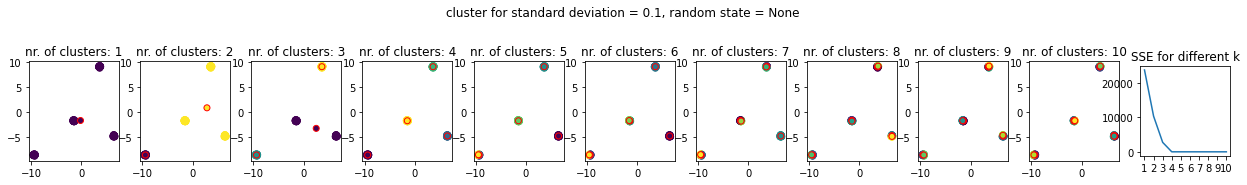

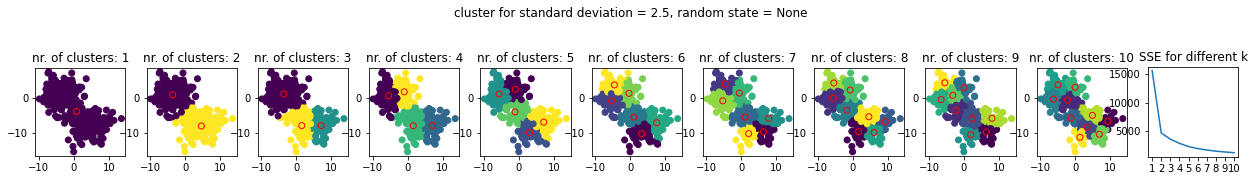

In [4]:
for cluster, std in zip([cluster_a, cluster_b, cluster_c], [0.6, 0.1, 2.5]):
    get_clustering(cluster, std)

We can see that the clusters are differently spread out, depending on the standard deviation. It can be stated that the bigger the deviation the bigger the blobs. At standard deviation 2.5 it's actually hard to see the different blops. Consequently we can see how the SSE behaves differently for the different standard deviations. For deviation = 0.1 the sse curve indicates that there are actually 4 different clusters. An observation that is easily backed up when looking at the plots. Deviation = 0.6 behaves not as clearly. I've run the experiment a couple of times and there are blop distributions that are already linked to a very low SSE for k=3. Contrary to this Deviation = 2.5 behaves differently in the sense that 10 clusters perform significantly better than 9 clusters. This indicates that for blobs spread out over a large area we'd need higher number of clusters to minimize the SSE. An insight that is very trivial.

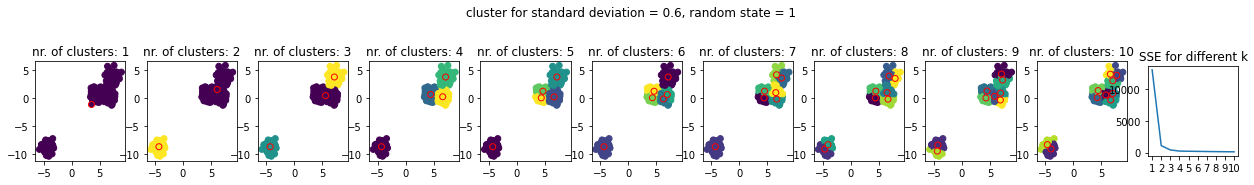

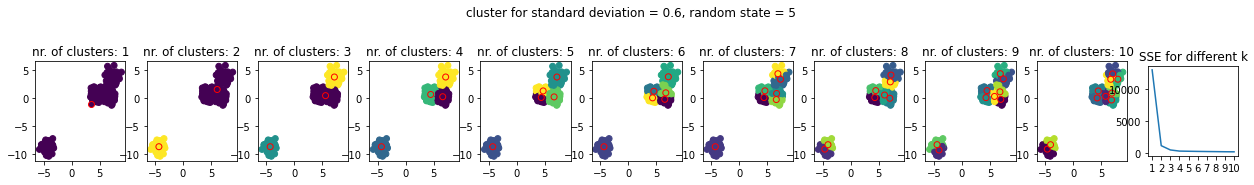

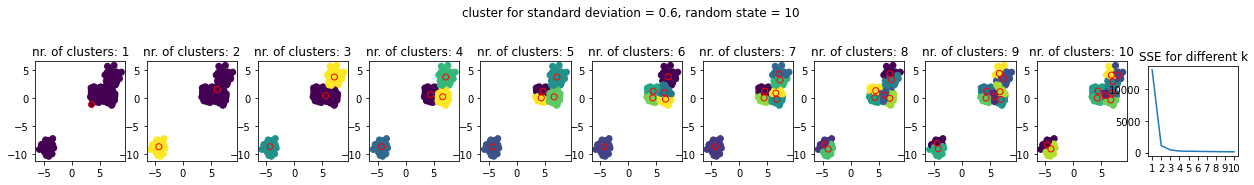

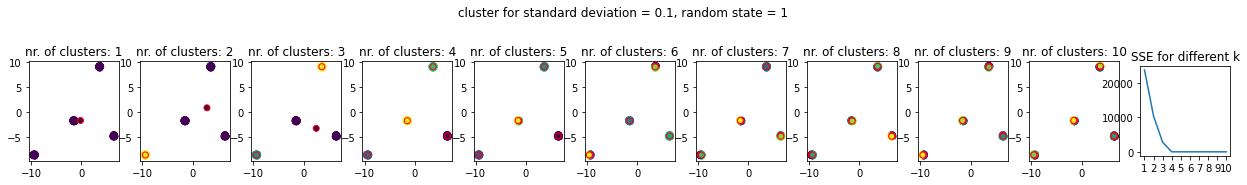

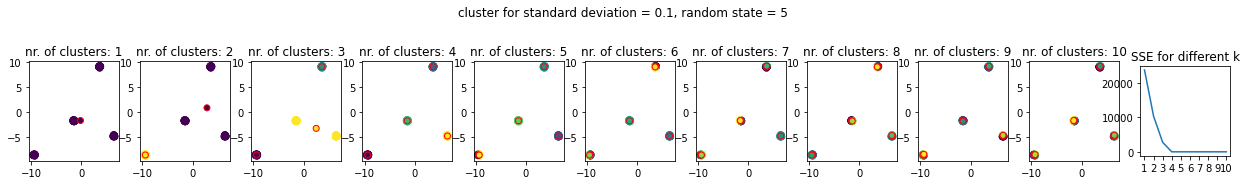

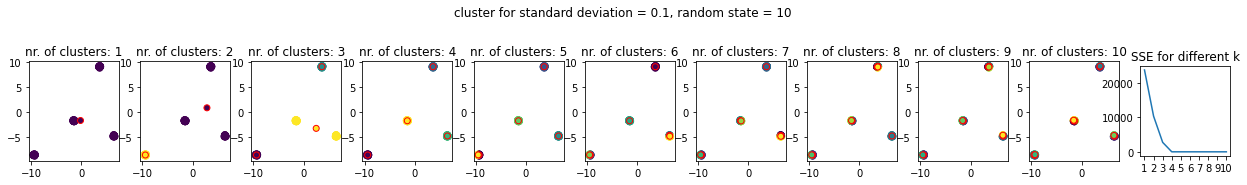

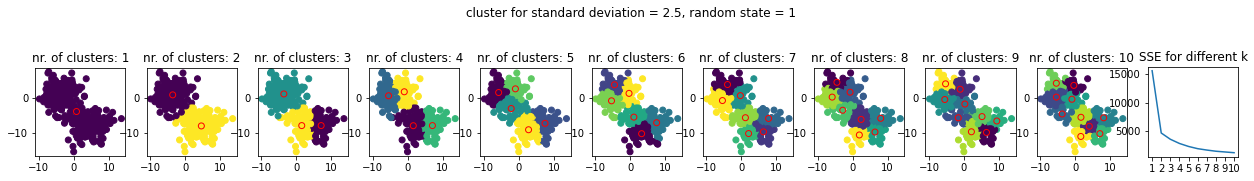

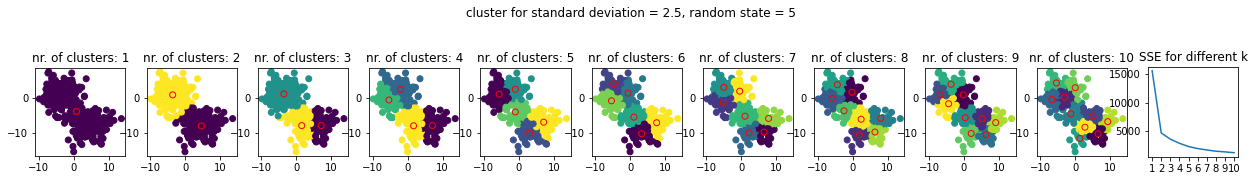

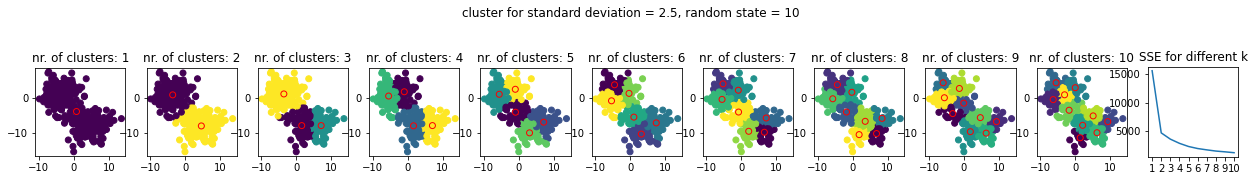

In [5]:
for cluster, std in zip([cluster_a, cluster_b, cluster_c], [0.6, 0.1, 2.5]):
    for r in [1,5,10]:
        get_clustering(cluster, std, r)

The implementation of k-means relies on randomness in order to find the first set of centroids. Accordingly each different random state produces a different result. However, these differences are only appearent after the actual number of clusters is reached. Meaning that the algorithm produces similar results for k <= 4. with k > 4 the solutions start to differgate. It's not supprising that this is the case, given that the data is distributed into 4 blobs. However these changes do not influence the SSE, which seems to be constant for the different random states. One possible way to chane that would be to have the algorithm start at k fixed locations in the grid provided by the min-max values on all axes. This would ensure that the results stay the same.

# Assignment 2

In [88]:
data = pd.read_csv('vertebrate.csv')
data


,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


In [89]:
data = data.convert_dtypes()
data['Class'] = data['Class'].astype(object)
data = pd.get_dummies(data)

In [72]:
from scipy.cluster.hierarchy import dendrogram, single, complete, average
from scipy.spatial.distance import pdist

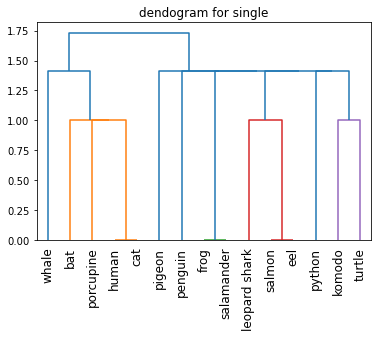

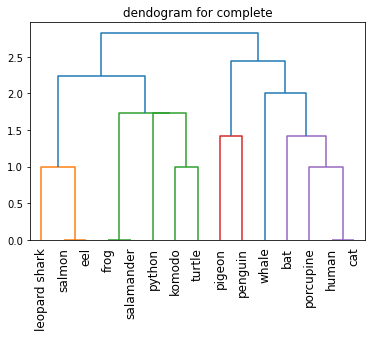

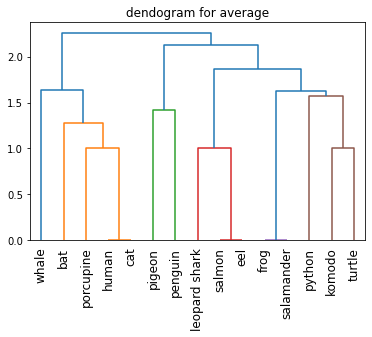

In [83]:
distances = pdist(data.iloc[:,1:-1].astype(int).values)
for i in [single, complete, average]:
    Z = i(distances)
    dendrogram(Z, labels= data.iloc[:,0].values)
    plt.xticks(rotation=90)
    plt.title(f'dendogram for {i.__name__}')
    plt.show()

I'd argue that the representation provided by 'average' is the best, simply because the distinction between mammals and non-mammals is the most natural to me. This difference is also given in the 'single' dendogram. However, due to the fact that the rest is clustered into one major subclass is somewhat off in this solution. Comparing 'complete' and 'average' I'd still argue for 'average', simply because birds are closer to reptiles (given that both produce egs) than to mammals. Generally speaking it's obvious that the best (most natural) solution depends highly on the metric used to evaluate this.

# Assignment 3

In [90]:
from sklearn.cluster import DBSCAN

In [94]:
data = pd.read_csv('chameleon.csv')
data

,x,y
0,650.914,214.888
1,41.767,179.408
2,509.126,233.749
3,486.403,152.427
4,46.883,367.904
...,...,...
1966,631.430,210.478
1967,187.652,247.923
1968,124.996,264.847
1969,522.511,302.785


In [136]:
dbscan = DBSCAN(eps=15.5, min_samples=5)
class_pred = dbscan.fit_predict(data)
data['labels'] = class_pred

Text(0.5, 1.0, 'solutions for (b)')

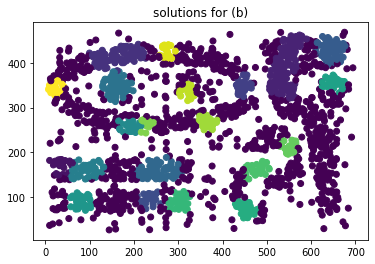

In [140]:
plt.scatter(data['x'], data['y'], c=data['labels'])
plt.title('solutions for (b)')

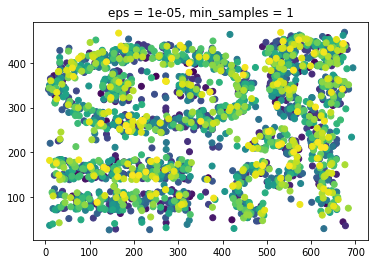

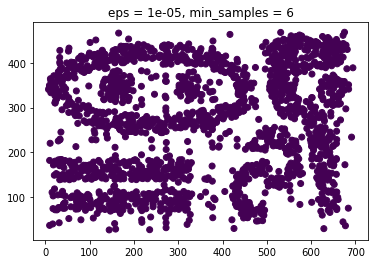

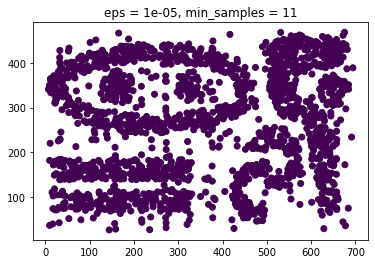

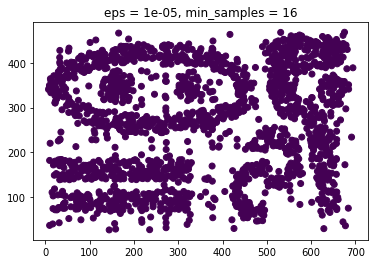

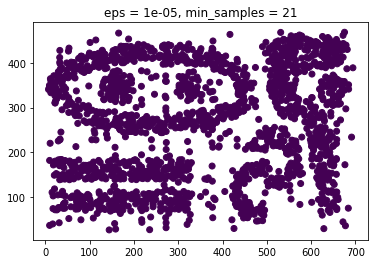

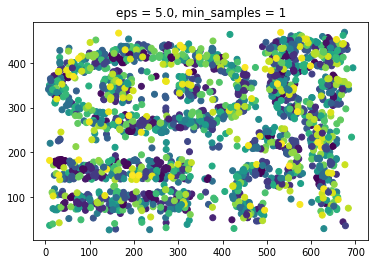

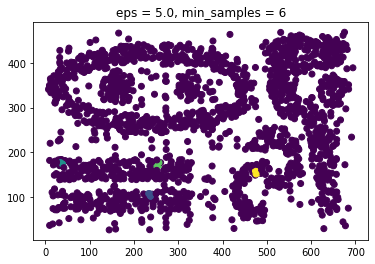

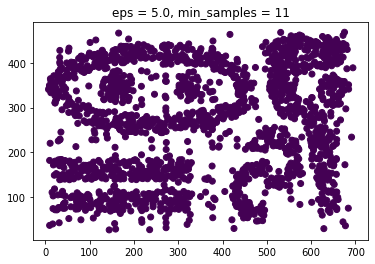

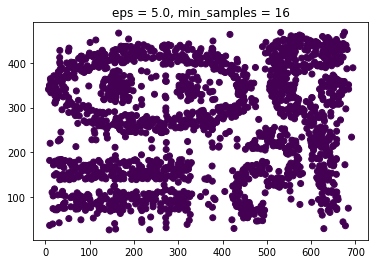

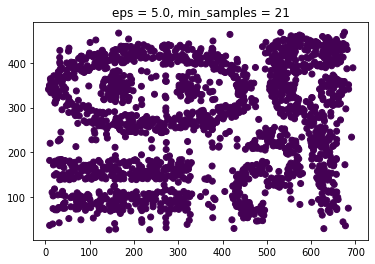

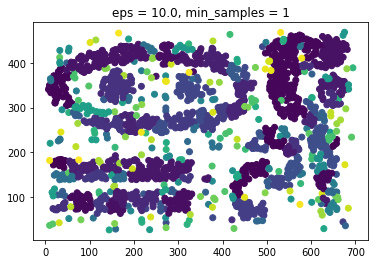

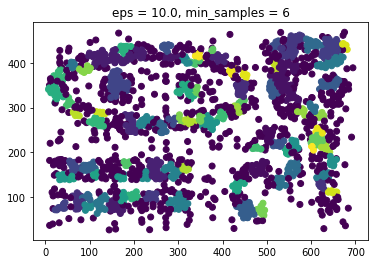

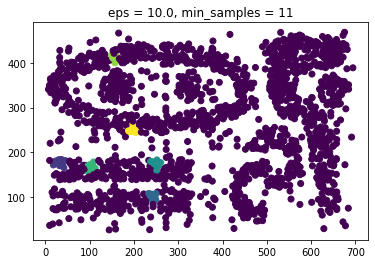

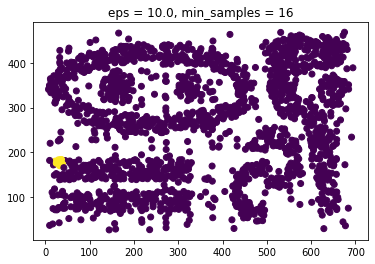

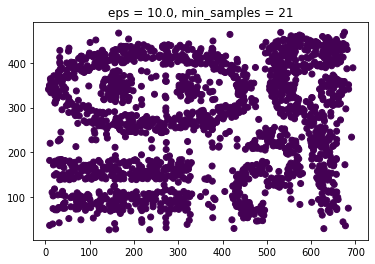

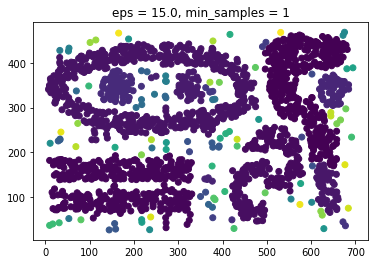

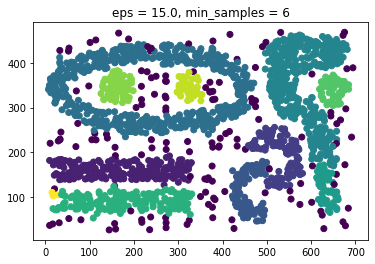

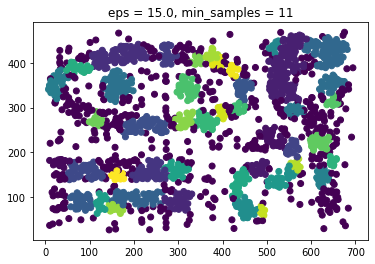

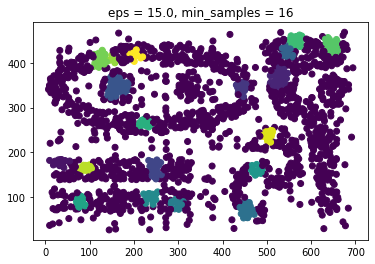

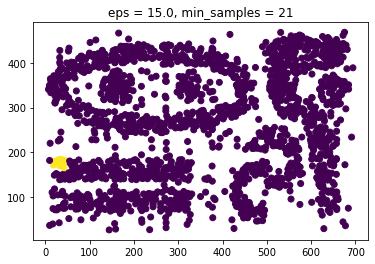

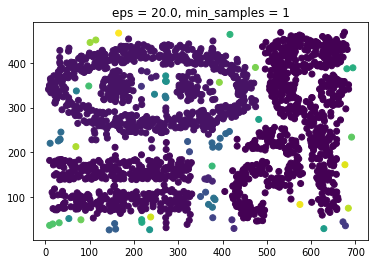

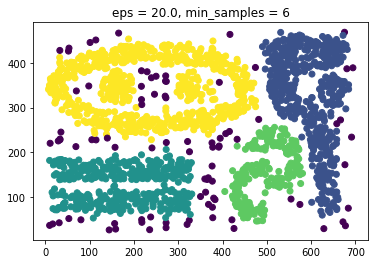

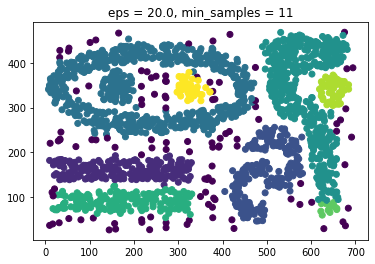

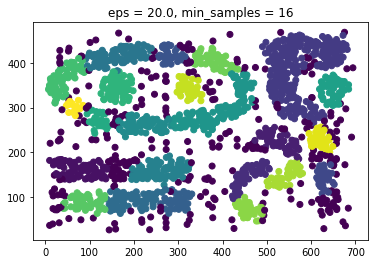

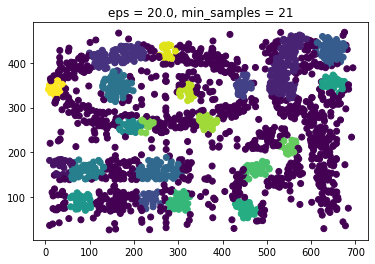

In [139]:
for eps in np.hstack((1e-5,np.arange(5,21,5))):
    for min_sample in range(1,22,5):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        class_pred = dbscan.fit_predict(data)
        data['labels'] = class_pred
        plt.scatter(data['x'], data['y'], c=data['labels'])
        plt.title(f'eps = {eps}, min_samples = {min_sample}')
        plt.show()

The result provided in (b) seems to be the best. However, some solutions in (c) can be considered good as well. especially eps=15 and min_samples=6 (unsuprisingly as this is quite close to the parameters used in (b)), eps=20 and min_samples=6 and eps=20 and min_samples=11. Generally speaking we get an increased number of clusters with increasing min_samples, which peaks at some number, after which no points in the neighborhood of another point can be found. Eps on the other hand seems to have a severe influence on the size of the obtained clusters. Which is backed up by the documentation which describes eps as [The maximum distance between two samples for one to be considered as in the neighborhood of the other](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
